# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')
import re
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:
df = pd.read_csv('vaccination_tweets.csv')

In [3]:
# first five rows of the dataset
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
# basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10340 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [5]:
# checking for null values
df.isnull().sum()

id                     0
user_name              0
user_location       2270
user_description     680
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [6]:
# taking only the text column
text_df = df[['text']]
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [7]:
# printing the first five texts
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 

Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq 



In [8]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11020 non-null  object
dtypes: object(1)
memory usage: 86.2+ KB


# Preprocessing

In [9]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [10]:
text_df['text'] = text_df['text'].apply(data_processing)

In [11]:
# printing the first five text after applying preprocessing
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

folks said daikon paste could treat cytokine storm pfizerbiontech 

world wrong side history year hopefully biggest vaccination effort weve ev 

coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_19 russian vaccine created last 24 years 

facts immutable senator even youre ethically sturdy enough acknowledge 1 born 

explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech 



In [12]:
text_df = text_df.drop_duplicates('text')

In [13]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [14]:
text_df['text'] = text_df['text'].apply(lambda x: stemming(x))
text_df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...


In [15]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

folks said daikon paste could treat cytokine storm pfizerbiontech 

world wrong side history year hopefully biggest vaccination effort weve ev 

coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_19 russian vaccine created last 24 years 

facts immutable senator even youre ethically sturdy enough acknowledge 1 born 

explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech 



In [16]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10543 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10543 non-null  object
dtypes: object(1)
memory usage: 164.7+ KB


# Sentiment Analysis

In [17]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [18]:
text_df['polarity'] = text_df['text'].apply(polarity)

In [19]:
text_df.head(10)

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.000
1,world wrong side history year hopefully bigges...,-0.500
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000
3,facts immutable senator even youre ethically s...,0.100
4,explain need vaccine borisjohnson matthancock ...,0.000
5,anyone useful adviceguidance whether covid vac...,0.400
6,bit sad claim fame success vaccination patriot...,-0.100
7,many bright days 2020 best 1 bidenharris winni...,0.675
8,covid vaccine getting covidvaccine covid19 pfi...,0.000
9,covidvaccine states start getting covid19vacci...,0.000


In [20]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [21]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [22]:
text_df.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positive
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral


# Visualization

<Axes: xlabel='sentiment', ylabel='count'>

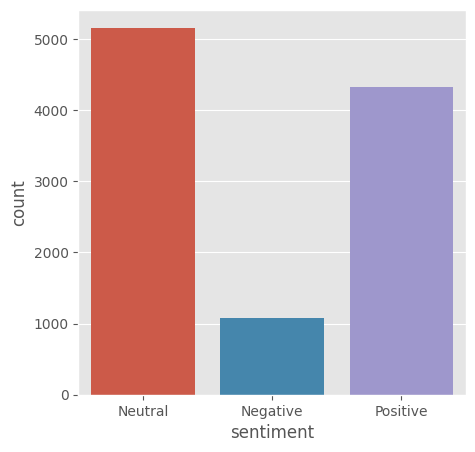

In [23]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

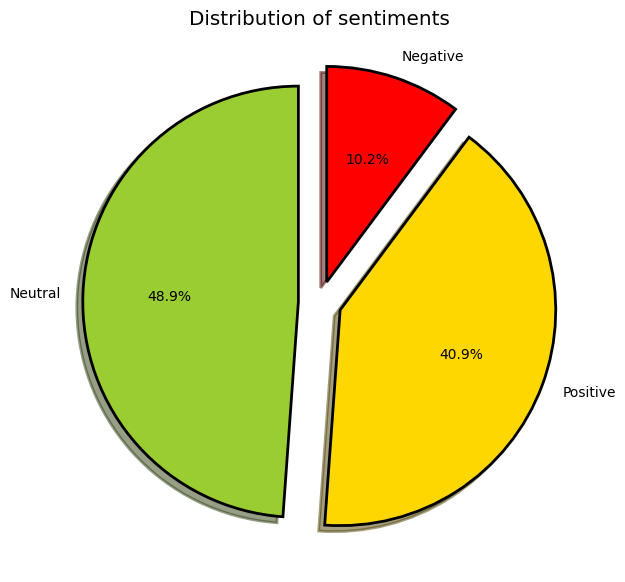

In [24]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [25]:
pos_tweets = text_df[text_df['sentiment'] == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,text,polarity,sentiment
9317,best way get merrygoround pfizer pfizerbiontec...,1.0,Positive
2340,applying emotion pfizerbiontech based best evi...,1.0,Positive
6295,pfizer jab morning efficient wellorganised tha...,1.0,Positive
5041,get art printed awesome products support redbu...,1.0,Positive
1055,already vaccinated getting vaccine soon plan t...,1.0,Positive


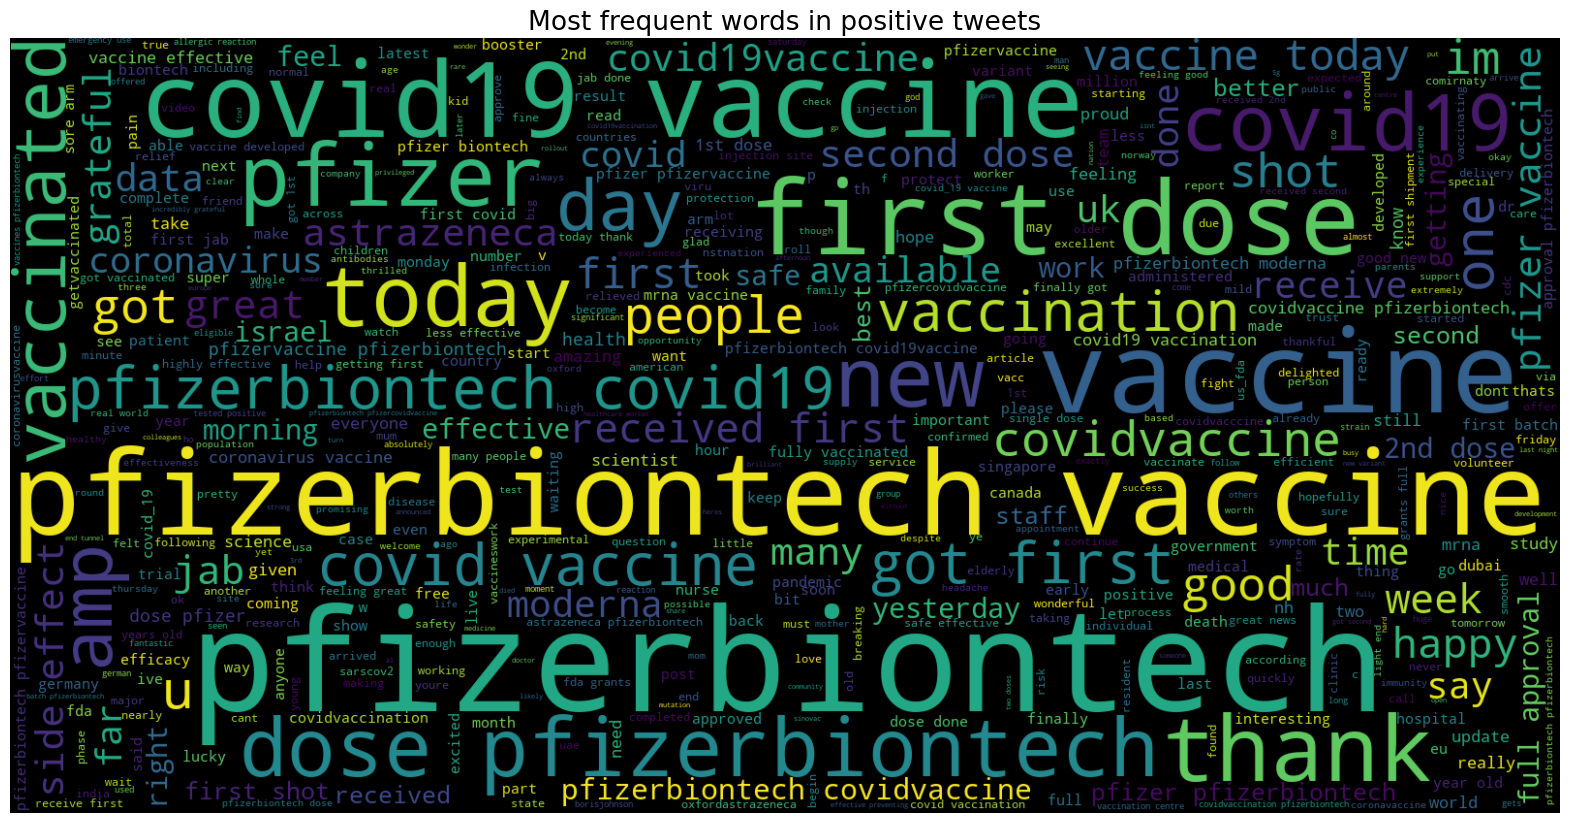

In [26]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [27]:
neg_tweets = text_df[text_df['sentiment'] == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,text,polarity,sentiment
2912,work skilled nursing facility got first vaccin...,-0.003333,Negative
7256,200321 752308 vaccinations new daily record da...,-0.003409,Negative
2073,ukgovernment cant even vaccinate properly ethi...,-0.004762,Negative
7715,got first dose less waiting time airport vacci...,-0.005556,Negative
7157,nas_k27 second dose due end next month well fa...,-0.006250,Negative


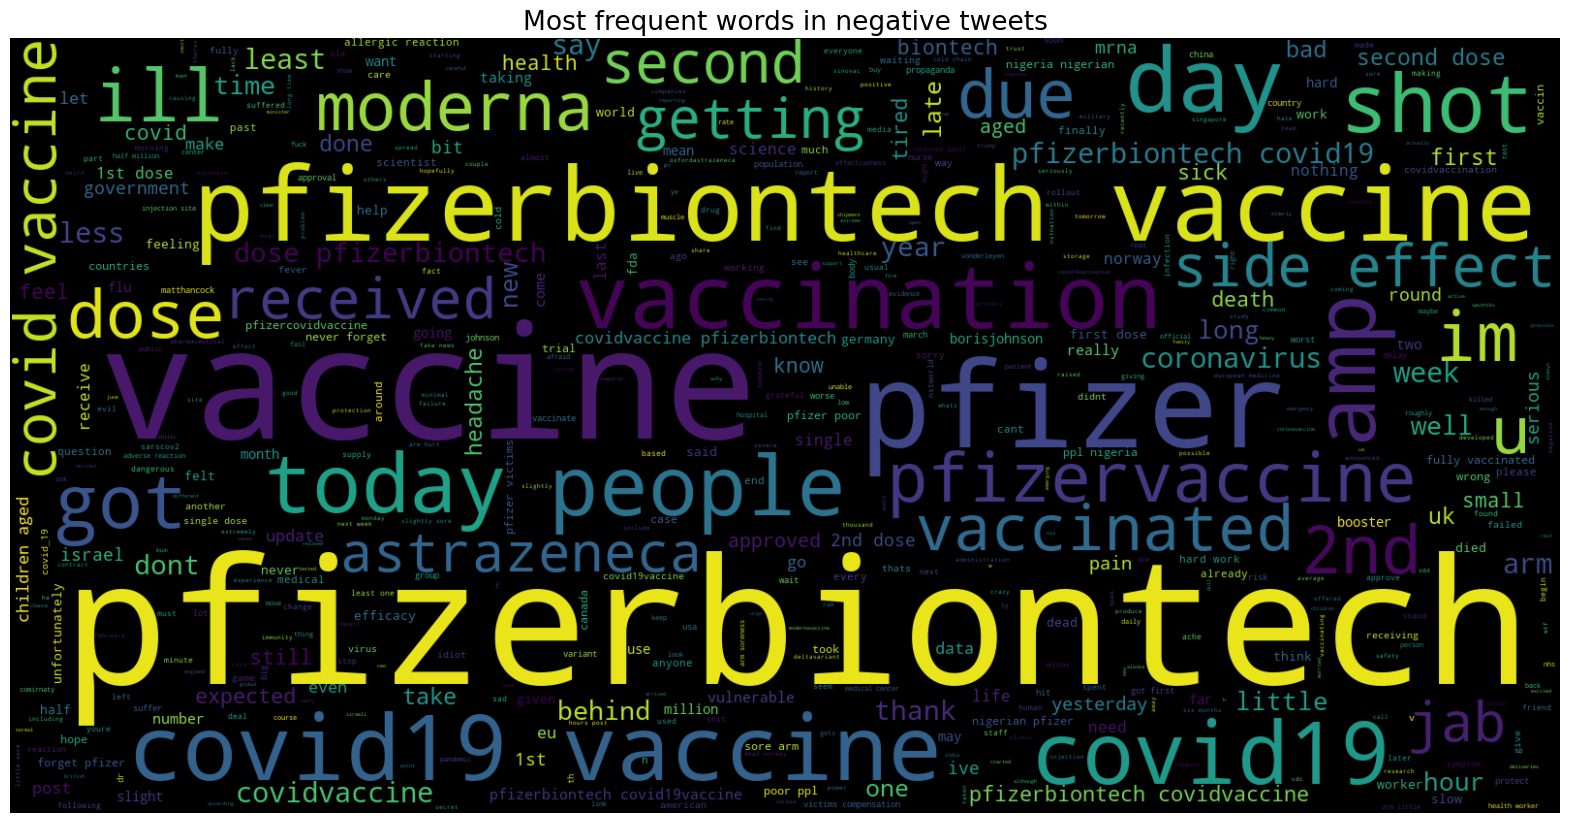

In [28]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [29]:
neutral_tweets = text_df[text_df['sentiment'] == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
7347,anyone else feel like framing vaccine card pfi...,0.0,Neutral
7458,looking forward getting second pfizer shot any...,0.0,Neutral
7454,never thought id running diff vaccine modernav...,0.0,Neutral
7453,john___m dont get choose one person know asked...,0.0,Neutral


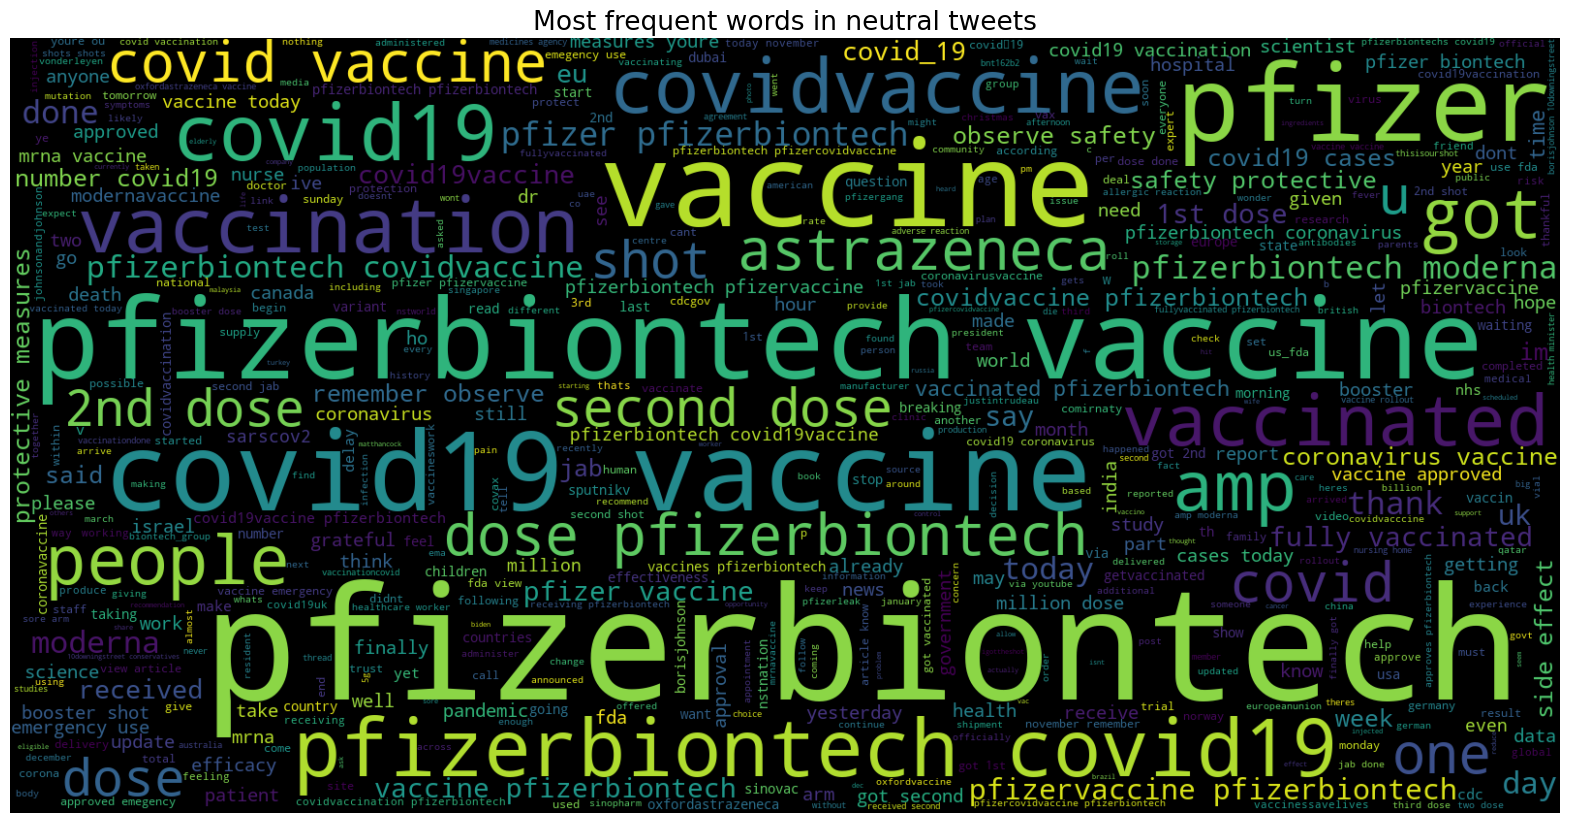

In [30]:
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

# Bag of words

In [31]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])

In [32]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 78583

First 20 features:
 ['000' '000 doses' '000 initial' '000 people' '000 vaccines' '0000001'
 '0000001 covid19' '0011' '0011 abt' '004' '004 covid' '004 israelis' '01'
 '01 getting' '01 june' '01 november' '01aug2021' '01aug2021 doublevaxxed'
 '02' '02 175']


In [33]:
x = text_df['text']
Y = text_df['sentiment']
X = vect.transform(x)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [35]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (7907, 78583)
Size of y_train: (7907,)
Size of x_test: (2636, 78583)
Size of y_test: (2636,)


# Logistic Regression

In [36]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(y_test, logreg_pred)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 84.18%


In [37]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[  80  159   44]
 [   3 1255   12]
 [   9  190  884]]


              precision    recall  f1-score   support

    Negative       0.87      0.28      0.43       283
     Neutral       0.78      0.99      0.87      1270
    Positive       0.94      0.82      0.87      1083

    accuracy                           0.84      2636
   macro avg       0.86      0.70      0.72      2636
weighted avg       0.86      0.84      0.83      2636



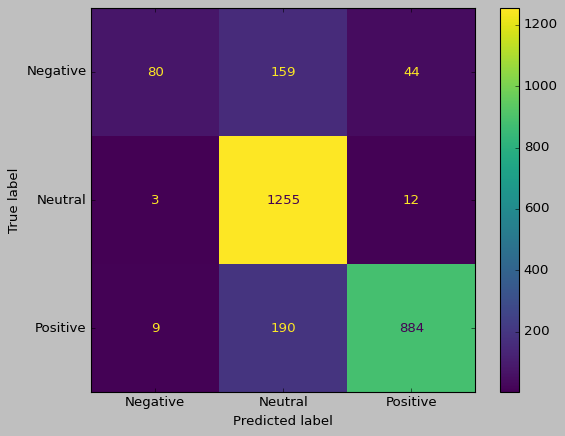

In [38]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

# Hyperparameter Tuning

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [41]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 10}


In [42]:
y_pred = grid.predict(x_test)

In [43]:
logreg_acc_new = accuracy_score(y_test, y_pred)
print("Test accuracy: {:.2f}%".format(logreg_acc_new*100))

Test accuracy: 85.74%


In [44]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 100  141   42]
 [   2 1256   12]
 [  11  168  904]]


              precision    recall  f1-score   support

    Negative       0.88      0.35      0.51       283
     Neutral       0.80      0.99      0.89      1270
    Positive       0.94      0.83      0.89      1083

    accuracy                           0.86      2636
   macro avg       0.88      0.73      0.76      2636
weighted avg       0.87      0.86      0.85      2636



# SVM

In [45]:
from sklearn.svm import LinearSVC

In [46]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [47]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(y_test, svc_pred)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 87.06%


In [48]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[ 121  122   40]
 [   5 1254   11]
 [  12  151  920]]


              precision    recall  f1-score   support

    Negative       0.88      0.43      0.57       283
     Neutral       0.82      0.99      0.90      1270
    Positive       0.95      0.85      0.90      1083

    accuracy                           0.87      2636
   macro avg       0.88      0.75      0.79      2636
weighted avg       0.88      0.87      0.86      2636



In [49]:
param_grids = {
    'C':[0.01, 0.1, 1, 10],
}
grid1 = GridSearchCV(SVCmodel, param_grids)
grid1.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.01, 0.1, 1, 10]})

In [50]:
print("Best parameter:", grid1.best_params_)

Best parameter: {'C': 10}


In [51]:
y_pred1 = grid1.predict(x_test)

In [52]:
svc_acc_new = accuracy_score(y_test, y_pred1)
print("Test accuracy: {:.2f}%".format(svc_acc_new*100))

Test accuracy: 87.29%


In [53]:
print(confusion_matrix(y_test, y_pred1))
print("\n")
print(classification_report(y_test, y_pred1))

[[ 127  119   37]
 [   6 1253   11]
 [  12  150  921]]


              precision    recall  f1-score   support

    Negative       0.88      0.45      0.59       283
     Neutral       0.82      0.99      0.90      1270
    Positive       0.95      0.85      0.90      1083

    accuracy                           0.87      2636
   macro avg       0.88      0.76      0.80      2636
weighted avg       0.88      0.87      0.86      2636

